In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import numpy as np
import statistics
import tensorflow as tf
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt
import re
import numpy.matlib
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
from keras.utils import to_categorical  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
import time

In [ ]:
# Συνάρτηση για τις συναρτήσεις ενεργοποίησης που χρησιμοποιούμε
# layer είναι η είσοδος της συνάρτησης 
# function καθορίζει ποια συνάρτηση θα χρησιμοποιήσουμε
# Επιστρέφει το αποτέλεσμα της συνάρτησης 
def activation(layer,function):
  # σιγμοειδής συνάρτηση 
  if (function == 'sigmoid'):
    layer = [1/(1+math.e**(-x)) for x in layer]
  # softmax συνάρτηση
  elif (function == 'softmax'):
    # υπολογίζουμε το e^(x-max)/sum(e^(x-max)) για αποφύγουμε το overflow 
    max = np.amax(layer)
    layer1 = layer - max 
    mysum = np.sum(np.exp(layer1))
    layer = [math.e**(x)/mysum for x in layer1]
  layer = np.array(layer)
  return layer

In [15]:
# Συνάρτηση που επιστρέφει το ποσοστό επιτυχίας (για labels με one-hot encoding)
# Ως όρισμα δέχεται δύο λίστες και υπολογίζει το ποσοστό στο οποίο είναι ίδιες
# Επιστρέφει το ποσοστό επιτυχίας
def accuracy(y,d):
  e = [1 for x1,x2 in zip(y,d) if (np.argmax(x1)==np.argmax(x2)) ]
  return len(e)/len(y)

In [24]:
# Συνάρτηση που μετατρέπει τα δεδομένα σε αριθμητικά δεδομένα
# train_X,test_X,train_y,test_y είναι τα δεδομένα 
# Επιστρέφει τα δεδομένα σε αριθμητική μορφή 
def transform_from_data(train_X,train_y,test_X,test_y):
  # μετατροπή δεδομένων εισόδου σε αριθμητικά διανύσματα μεγέθους 60
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(train_X)

  train_X = tokenizer.texts_to_sequences(train_X)
  test_X = tokenizer.texts_to_sequences(test_X)
 
  train_X =  pad_sequences(train_X,padding='post',maxlen=60)
  test_X =  pad_sequences(test_X,padding='post',maxlen=60)

  vocab_size = len(tokenizer.word_index)+1 #μέγεθος λεξιλογίου

  #μετατροπή labels σε αριθμητικά δεδομένα 
  train_y1 =[]
  for x in train_y:
    if (x == "['positive']"): 
      train_y1.append(2)
    elif (x == "['neutral']"):
      train_y1.append(1)
    else:
      train_y1.append(0)
   

  test_y1 =[]
  for x in test_y:
    if (x == "['positive']"): 
      test_y1.append(2)
    elif (x == "['neutral']"):
      test_y1.append(1)
    else:
      test_y1.append(0)
  

  return train_X,test_X,train_y1,test_y1,vocab_size


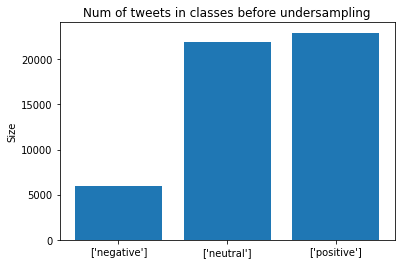

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


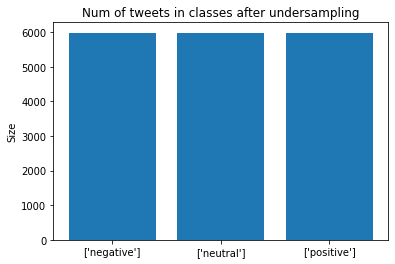

In [25]:
#φορτωσή δεδομένων 
data = pd.read_csv('bitcointweets.csv', header=None) 

X = data[1] # δεδομένα εισόδου
y = data[7] # labels

X = np.array(X)
y = np.array(y)
# παρουσίαση πλήθους δεδομένων για κάθε κλάση
y_labels = pd.DataFrame(y,columns=['label'])
y_labels = y_labels.groupby('label').size().reset_index(name='count')
plt.bar(y_labels['label'], y_labels['count'], align='center')
plt.ylabel('Size')
plt.title('Num of tweets in classes before undersampling')
plt.show()

# εφαρμογή undersampling στα δεδομένα
X = X.reshape(-1,1)
rus = RandomUnderSampler()
X,y = rus.fit_resample(X,y)
X= X.flatten()

# παρουσίαση πλήθους δεδομένων μετά το undresampling

y_labels = pd.DataFrame(y,columns=['label'])
y_labels = y_labels.groupby('label').size().reset_index(name='count')
plt.bar(y_labels['label'], y_labels['count'], align='center')
plt.ylabel('Size')
plt.title('Num of tweets in classes after undersampling')
plt.show()

# αφαίρεση mention και link από τα tweets
X = [re.sub(r'@\S+','',x) for x in X]
X = [re.sub(r'http\S+','',x) for x in X]


# διαχωρισμός των δεδομένων σε δεδομένα εκπαίδευσης και σε δεδομένα ελέγχου
train_X0, test_X0, train_y0, test_y0 = train_test_split(X,y,test_size=0.4)

# μετατροπή δεδομένων σε αριθμητικά
train_X,test_X,train_y1,test_y1,vocab_size = transform_from_data(train_X0,train_y0,test_X0,test_y0)

# μετατροπή labels σε one-hot 
train_y = to_categorical(train_y1,num_classes=3) 
test_y = to_categorical(test_y1,num_classes=3)


train_X = np.array(train_X)
test_X = np.array(test_X)

In [ ]:
n_samples = train_X.shape[0] # πλήθος δειγμάτων εκπαίδευσης
input_layer_dim = train_X.shape[1] # πλήθος νευρώνων επιπέδου εισόδου
hidden_layer_dim = 128 # πλήθος νευρώνων κρυφού επιπέδου
hidden_layer_function = 'sigmoid' # συνάρτηση ενεργοποίησης κρυφού επιπέδου
output_layer_dim = 3 # πλήθος νευρώνων επιπέδου εξόδου
output_layer_function = 'softmax' # συνάρτηση ενεργοποίησης επιπέδου εξόδου
learning_rate = 0.0001  # βαθμός μάθησης

# αρχικοποίηση βαρών με τυχαίους αριθμούς
input_to_hidden_layer_weights = np.random.uniform(size=(input_layer_dim,hidden_layer_dim),low=0,high=1)
hidden_to_output_layer_weights = np.random.uniform(size=(hidden_layer_dim,output_layer_dim),low=0,high=1)

input_layer = np.empty((input_layer_dim,1))
hidden_layer = np.empty((hidden_layer_dim,1)) 
output_layer = np.empty((output_layer_dim,1))

# bias των αντίστοιχων επιπέδων 
bias_hidden = np.random.uniform(size=(hidden_layer_dim),low=0,high=1)
bias_output = np.random.uniform(size=(output_layer_dim),low=0,high=1)

# δέλτα για κάθε νευρώνα 
d_output = np.empty((output_layer_dim,1))
d_hidden = np.empty((hidden_layer_dim,1))

batch_size = 1 # μέγεθος batch
epoch_size = 500 #πλήθος εποχών

# κανονικοποίηση αριθμών σε κλίμακα 0-1 (αποφυγή overflow)
train_X = train_X / vocab_size
test_X = test_X / vocab_size

In [ ]:
loss_plot = [] # loss για όλες τις εποχές (training)
ac_plot = [] # accuracy για όλες τις εποχές (training)
loss_val_plot =[] # loss για όλες τις εποχές (test)
acc_val_plot = [] # accuracy για όλες τις εποχές (test)
n_samples_test = test_X.shape[0] # πλήθος δεδομένων ελέγχου
for i in range(0,epoch_size):
  mysum = np.array([0.0,0.0,0.0]) #συνολικό σφάλμα σε κάθε batch
  output = [] # αποτέλεσμα νευρωνικού για κάθε δείγμα
  loss_epoch = 0 # loss για την συγκεκριμένη εποχή 
  train_X, train_y = shuffle(train_X, train_y) # ανακάτεμα δεδομένων για αποφυγή "παπαγαλίας" του δικτύου 
  for j,x in enumerate(train_X):
      input_layer = x
      # υπολογισμός κρυφού επιπέδου
      hidden_layer = np.dot(input_to_hidden_layer_weights.T,input_layer) + bias_hidden 
      hidden_layer = activation(hidden_layer,hidden_layer_function)
      # υπολογισμός επιπέδου εξόδου 
      output_layer = np.dot(hidden_to_output_layer_weights.T,hidden_layer) + bias_output
      output_layer = activation(output_layer,output_layer_function)

      output.append(output_layer)
     
      # υπολογισμός σφάλματος
      total_error = train_y[j] - output_layer
      loss_epoch += 1/2 * np.sum(np.square(total_error))
      mysum+= total_error 

      #print(loss_epoch)
      # έλεγχος αν πρέπει να ενημερώσουμε τα βάρη
      if ((j+1) % batch_size == 0):
        # υπολογισμός δέλτα
        output_error = mysum/batch_size
        d_output = np.multiply(output_error,np.multiply(output_layer,1-output_layer))
        d_hidden = np.multiply(np.dot(hidden_to_output_layer_weights,d_output) , np.multiply(hidden_layer,1-hidden_layer)) 
        
        d_output = d_output.reshape(output_layer_dim,1)
        d_hidden = d_hidden.reshape(hidden_layer_dim,1)
        hidden_layer = hidden_layer.reshape(hidden_layer_dim,1)
        output_layer = output_layer.reshape(output_layer_dim,1)
        input_layer = input_layer.reshape(input_layer_dim,1)
        bias_hidden= bias_hidden.reshape(hidden_layer_dim,1)
        bias_output = bias_output.reshape(output_layer_dim,1)

        # υπολογισμός μεταβολής βαρών
        temp_h_o = learning_rate * np.dot(hidden_layer,d_output.T)
        temp_i_h = learning_rate * np.dot(input_layer,d_hidden.T)
        
        # ενημέρωση βαρών
        hidden_to_output_layer_weights += temp_h_o
        input_to_hidden_layer_weights +=  temp_i_h

        # ενημέρωση bias
        bias_hidden +=  learning_rate * d_hidden
        bias_output += learning_rate * d_output

        bias_hidden = bias_hidden.flatten()
        bias_output = bias_output.flatten()

        mysum = np.array([0.0,0.0,0.0])

      elif (j==(n_samples-1)): # σε περίπτωση που το batch δεν διαιρεί ακριβώς το πλήθος των δεδομένων ενημερώνουμε τα βάρη για τα δείγματα που έμειναν
        output_error = mysum/((j+1) % batch_size)
        # υπολογισμός δέλτα 
        d_output = np.multiply(output_error,np.multiply(output_layer,1-output_layer))
        d_hidden = np.multiply(np.dot(hidden_to_output_layer_weights,d_output) , np.multiply(hidden_layer,1-hidden_layer)) 

        d_output = d_output.reshape(output_layer_dim,1)
        d_hidden = d_hidden.reshape(hidden_layer_dim,1)
        hidden_layer = hidden_layer.reshape(hidden_layer_dim,1)
        output_layer = output_layer.reshape(output_layer_dim,1)
        input_layer = input_layer.reshape(input_layer_dim,1)
        bias_hidden= bias_hidden.reshape(hidden_layer_dim,1)
        bias_output = bias_output.reshape(output_layer_dim,1)
       
        # υπολογισμός μεταβολής βαρών 
        temp_h_o = learning_rate * np.dot(hidden_layer,d_output.T)
        temp_i_h = learning_rate * np.dot(input_layer,d_hidden.T)
        
        #ενημέρωση βαρών 
        hidden_to_output_layer_weights = hidden_to_output_layer_weights + temp_h_o
        input_to_hidden_layer_weights = input_to_hidden_layer_weights + temp_i_h

        # ενημέρωση bias
        bias_hidden = bias_hidden + learning_rate * d_hidden
        bias_output = bias_output + learning_rate * d_output


        bias_hidden = bias_hidden.flatten()
        bias_output = bias_output.flatten()

       
        mysum = np.array([0.0,0.0,0.0])
  # υπολογισμός loss και accuracy για την εποχή
  loss_epoch/= n_samples
  loss_plot.append(loss_epoch)
  ac_plot.append(accuracy(output,train_y))
  print("Epoch %d -> Accuracy %f , Loss %f" %(i,accuracy(output,train_y),loss_epoch))
  
  output_test = [] # αποτελέσματα νευρωνικού για όλα τα δείγματα ελέγχου
  loss_test = 0 # loss για τα δεδομένα ελέγχου
  n_samples_test = test_X.shape[0] #πλήθος δεδομένων ελέγχου
  for k,x1 in enumerate(test_X):
    input_layer = x1
    # υπολογισμός κρυφού επιπέδου
    hidden_layer = np.dot(input_to_hidden_layer_weights.T,input_layer) 
    hidden_layer = activation(hidden_layer,hidden_layer_function)
    # υπολογισμός επιπέδου εξόδου
    output_layer = np.dot(hidden_to_output_layer_weights.T,hidden_layer)
    output_layer = activation(output_layer,output_layer_function)
  
    output_test.append(output_layer)
     
    # υπολογισμός σφάλματος 
    total_error = train_y[k] - output_layer
    loss_test += 1/2 * np.sum(np.square(total_error))
  
  #υπολογισμός loss και accuracy 
  loss_test/= n_samples_test
  loss_val_plot.append(loss_test)
  acc_val_plot.append(accuracy(output_test,test_y))

     
      

Epoch 0 -> Accuracy 0.345529 , Loss 0.384081
Epoch 1 -> Accuracy 0.329743 , Loss 0.333910
Epoch 2 -> Accuracy 0.319528 , Loss 0.333028
Epoch 3 -> Accuracy 0.326586 , Loss 0.332987
Epoch 4 -> Accuracy 0.321850 , Loss 0.332914
Epoch 5 -> Accuracy 0.335964 , Loss 0.332845
Epoch 6 -> Accuracy 0.328257 , Loss 0.332833
Epoch 7 -> Accuracy 0.321571 , Loss 0.332786
Epoch 8 -> Accuracy 0.331136 , Loss 0.332686
Epoch 9 -> Accuracy 0.330021 , Loss 0.332620
Epoch 10 -> Accuracy 0.327236 , Loss 0.332559
Epoch 11 -> Accuracy 0.331414 , Loss 0.332562
Epoch 12 -> Accuracy 0.329186 , Loss 0.332514
Epoch 13 -> Accuracy 0.331879 , Loss 0.332424
Epoch 14 -> Accuracy 0.325007 , Loss 0.332407
Epoch 15 -> Accuracy 0.333179 , Loss 0.332315
Epoch 16 -> Accuracy 0.335314 , Loss 0.332260
Epoch 17 -> Accuracy 0.325936 , Loss 0.332251
Epoch 18 -> Accuracy 0.333086 , Loss 0.332169
Epoch 19 -> Accuracy 0.322128 , Loss 0.332159
Epoch 20 -> Accuracy 0.330300 , Loss 0.332071
Epoch 21 -> Accuracy 0.330764 , Loss 0.33203

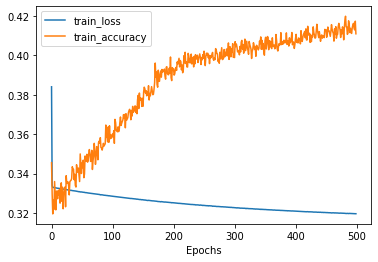

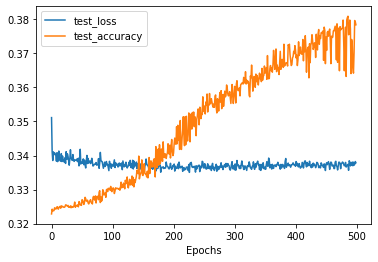

In [ ]:
# εμφάνιση αποτελέσμάτων
plt.plot(range(0,epoch_size),loss_plot,label="train_loss")
plt.plot(range(0,epoch_size),ac_plot,label="train_accuracy")
plt.legend()
plt.xlabel(xlabel="Epochs")
plt.show()

plt.plot(range(0,epoch_size),loss_val_plot,label="test_loss")
plt.plot(range(0,epoch_size),acc_val_plot,label="test_accuracy")
plt.legend()
plt.xlabel(xlabel="Epochs")
plt.show()

Νευρωνικά χτησιμοποιώντας το framework Keras

Νευρωνικά με loss_function = mse

Epoch 1/500
337/337 [==============================] - 1s 2ms/step - loss: 0.1781 - accuracy: 0.5766 - val_loss: 0.1699 - val_accuracy: 0.6068
Epoch 2/500
337/337 [==============================] - 1s 2ms/step - loss: 0.1569 - accuracy: 0.6406 - val_loss: 0.1684 - val_accuracy: 0.6096
Epoch 3/500
337/337 [==============================] - 1s 2ms/step - loss: 0.1496 - accuracy: 0.6570 - val_loss: 0.1619 - val_accuracy: 0.6130
Epoch 4/500
337/337 [==============================] - 1s 2ms/step - loss: 0.1459 - accuracy: 0.6755 - val_loss: 0.1623 - val_accuracy: 0.6077
Epoch 5/500
337/337 [==============================] - 1s 2ms/step - loss: 0.1464 - accuracy: 0.6659 - val_loss: 0.1606 - val_accuracy: 0.6230
Epoch 6/500
337/337 [==============================] - 1s 2ms/step - loss: 0.1421 - accuracy: 0.6788 - val_loss: 0.1640 - val_accuracy: 0.6252
Epoch 7/500
337/337 [==============================] - 1s 2ms/step - loss: 0.1397 - accuracy: 0.6869 - val_loss: 0.1539 - val_accuracy: 0.6428

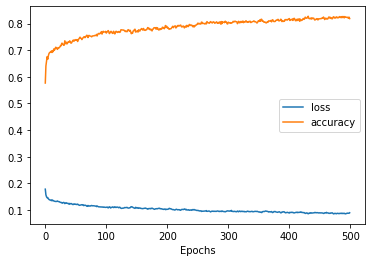

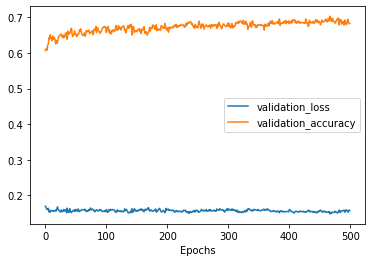

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Embedding,Input,Flatten
from keras.optimizers import Adam

# νευρωνικό δίκτυο με επίπεδο εισόδου 60 νευρώνων, ένα κρυφό με 512 νευρώνες sigmoid συνάρτηση ενεργοποίησης 
# και επίπεδο εξόδου με 3 νευρώνες με softmax συνάρτηση ενεργοποίησης

model = Sequential()
model.add(Input(60))
model.add(Dense(512,activation='sigmoid',use_bias=True))
model.add(Dense(3,activation='softmax',use_bias=True))
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])
history = model.fit(train_X,train_y,batch_size=32,epochs=500,validation_data=(test_X,test_y),shuffle=True)

#εμφάνιση αποτελεσμάτων
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['accuracy'],label="accuracy")
plt.legend()
plt.xlabel(xlabel="Epochs")
plt.show()

plt.plot(history.history['val_loss'],label="validation_loss")
plt.plot(history.history['val_accuracy'],label="validation_accuracy")
plt.legend()
plt.xlabel(xlabel="Epochs")
plt.show()

Epoch 1/500
337/337 [==============================] - 1s 3ms/step - loss: 0.1821 - accuracy: 0.5643 - val_loss: 0.1765 - val_accuracy: 0.5636
Epoch 2/500
337/337 [==============================] - 1s 3ms/step - loss: 0.1558 - accuracy: 0.6380 - val_loss: 0.1625 - val_accuracy: 0.6143
Epoch 3/500
337/337 [==============================] - 1s 2ms/step - loss: 0.1518 - accuracy: 0.6535 - val_loss: 0.1671 - val_accuracy: 0.6063
Epoch 4/500
337/337 [==============================] - 1s 2ms/step - loss: 0.1460 - accuracy: 0.6643 - val_loss: 0.1651 - val_accuracy: 0.6091
Epoch 5/500
337/337 [==============================] - 1s 2ms/step - loss: 0.1465 - accuracy: 0.6616 - val_loss: 0.1609 - val_accuracy: 0.6283
Epoch 6/500
337/337 [==============================] - 1s 3ms/step - loss: 0.1412 - accuracy: 0.6818 - val_loss: 0.1723 - val_accuracy: 0.5968
Epoch 7/500
337/337 [==============================] - 1s 2ms/step - loss: 0.1395 - accuracy: 0.6882 - val_loss: 0.1578 - val_accuracy: 0.6457

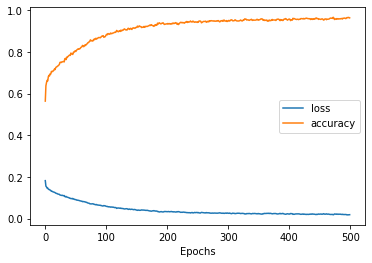

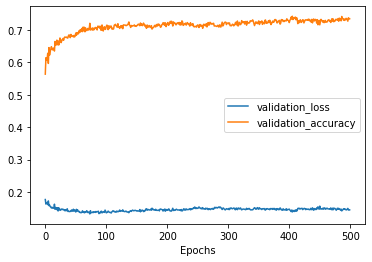

In [6]:
# νευρωνικό δίκτυο με επίπεδο εισόδου 60 νευρώνων, δύο κρυφά επίπεδο με 512 νευρώνες και 100 νευρώνες αντίστοιχα sigmoid συνάρτηση ενεργοποίησης 
# και επίπεδο εξόδου με 3 νευρώνες με softmax συνάρτηση ενεργοποίησης

model = Sequential()
model.add(Input(60))
model.add(Dense(512,activation='sigmoid',use_bias=True))
model.add(Dense(100,activation='sigmoid',use_bias=True))
model.add(Dense(3,activation='softmax',use_bias=True))
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])
history = model.fit(train_X,train_y,batch_size=32,epochs=500,validation_data=(test_X,test_y),shuffle=True)

#εμφάνιση αποτελεσμάτων
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['accuracy'],label="accuracy")
plt.legend()
plt.xlabel(xlabel="Epochs")
plt.show()

plt.plot(history.history['val_loss'],label="validation_loss")
plt.plot(history.history['val_accuracy'],label="validation_accuracy")
plt.legend()
plt.xlabel(xlabel="Epochs")
plt.show()

Epoch 1/500
337/337 [==============================] - 1s 4ms/step - loss: 0.1790 - accuracy: 0.5728 - val_loss: 0.1704 - val_accuracy: 0.5861
Epoch 2/500
337/337 [==============================] - 1s 3ms/step - loss: 0.1575 - accuracy: 0.6323 - val_loss: 0.1744 - val_accuracy: 0.5717
Epoch 3/500
337/337 [==============================] - 1s 3ms/step - loss: 0.1483 - accuracy: 0.6586 - val_loss: 0.1622 - val_accuracy: 0.6174
Epoch 4/500
337/337 [==============================] - 1s 3ms/step - loss: 0.1458 - accuracy: 0.6661 - val_loss: 0.1617 - val_accuracy: 0.6288
Epoch 5/500
337/337 [==============================] - 1s 3ms/step - loss: 0.1453 - accuracy: 0.6744 - val_loss: 0.1653 - val_accuracy: 0.5960
Epoch 6/500
337/337 [==============================] - 1s 3ms/step - loss: 0.1395 - accuracy: 0.6812 - val_loss: 0.1664 - val_accuracy: 0.6093
Epoch 7/500
337/337 [==============================] - 1s 3ms/step - loss: 0.1413 - accuracy: 0.6789 - val_loss: 0.1625 - val_accuracy: 0.6345

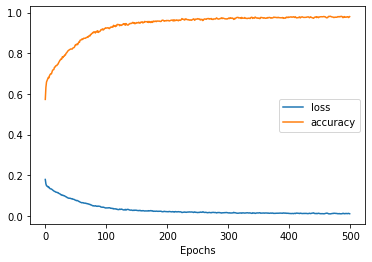

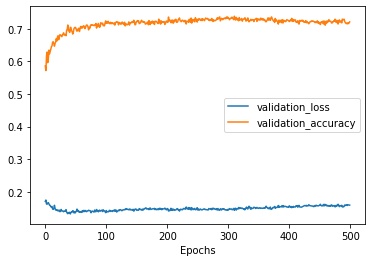

In [7]:
# νευρωνικό δίκτυο με επίπεδο εισόδου 60 νευρώνων, τρία κρυφά επίπεδα με sigmoid συνάρτηση ενεργοποίησης 
# και επίπεδο εξόδου με 3 νευρώνες με softmax συνάρτηση ενεργοποίησης

model = Sequential()
model.add(Input(60))
model.add(Dense(512,activation='sigmoid',use_bias=True))
model.add(Dense(256,activation='sigmoid',use_bias=True))
model.add(Dense(3,activation='softmax',use_bias=True))
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])
history = model.fit(train_X,train_y,batch_size=32,epochs=500,validation_data=(test_X,test_y),shuffle=True)

#εμφάνιση αποτελεσμάτων
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['accuracy'],label="accuracy")
plt.legend()
plt.xlabel(xlabel="Epochs")
plt.show()

plt.plot(history.history['val_loss'],label="validation_loss")
plt.plot(history.history['val_accuracy'],label="validation_accuracy")
plt.legend()
plt.xlabel(xlabel="Epochs")
plt.show()

Νευρωνικά με loss_function = categorical_crossentropy

Epoch 1/500
337/337 [==============================] - 1s 2ms/step - loss: 0.8892 - accuracy: 0.5872 - val_loss: 0.9004 - val_accuracy: 0.6014
Epoch 2/500
337/337 [==============================] - 1s 2ms/step - loss: 0.8102 - accuracy: 0.6384 - val_loss: 0.8542 - val_accuracy: 0.6149
Epoch 3/500
337/337 [==============================] - 1s 2ms/step - loss: 0.7761 - accuracy: 0.6592 - val_loss: 0.8361 - val_accuracy: 0.6171
Epoch 4/500
337/337 [==============================] - 1s 2ms/step - loss: 0.7673 - accuracy: 0.6609 - val_loss: 0.8970 - val_accuracy: 0.6046
Epoch 5/500
337/337 [==============================] - 1s 2ms/step - loss: 0.7711 - accuracy: 0.6585 - val_loss: 0.8967 - val_accuracy: 0.6089
Epoch 6/500
337/337 [==============================] - 1s 2ms/step - loss: 0.7537 - accuracy: 0.6701 - val_loss: 0.8535 - val_accuracy: 0.6192
Epoch 7/500
337/337 [==============================] - 1s 2ms/step - loss: 0.7479 - accuracy: 0.6639 - val_loss: 0.8859 - val_accuracy: 0.6117

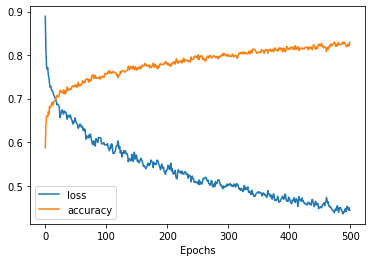

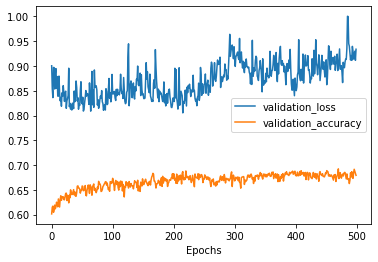

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Embedding,Input,Flatten
from keras.optimizers import Adam

# νευρωνικό δίκτυο με επίπεδο εισόδου 60 νευρώνων, ένα κρυφό με 512 νευρώνες sigmoid συνάρτηση ενεργοποίησης 
# και επίπεδο εξόδου με 3 νευρώνες με softmax συνάρτηση ενεργοποίησης

model = Sequential()
model.add(Input(60))
model.add(Dense(512,activation='sigmoid',use_bias=True))
model.add(Dense(3,activation='softmax',use_bias=True))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_X,train_y,batch_size=32,epochs=500,validation_data=(test_X,test_y),shuffle=True)

#εμφάνιση αποτελεσμάτων
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['accuracy'],label="accuracy")
plt.legend()
plt.xlabel(xlabel="Epochs")
plt.show()

plt.plot(history.history['val_loss'],label="validation_loss")
plt.plot(history.history['val_accuracy'],label="validation_accuracy")
plt.legend()
plt.xlabel(xlabel="Epochs")
plt.show()

Epoch 1/500
337/337 [==============================] - 1s 3ms/step - loss: 0.9249 - accuracy: 0.5625 - val_loss: 0.8866 - val_accuracy: 0.5908
Epoch 2/500
337/337 [==============================] - 1s 2ms/step - loss: 0.8138 - accuracy: 0.6323 - val_loss: 0.8818 - val_accuracy: 0.6058
Epoch 3/500
337/337 [==============================] - 1s 2ms/step - loss: 0.7875 - accuracy: 0.6428 - val_loss: 0.8639 - val_accuracy: 0.5974
Epoch 4/500
337/337 [==============================] - 1s 2ms/step - loss: 0.7648 - accuracy: 0.6606 - val_loss: 0.8792 - val_accuracy: 0.5990
Epoch 5/500
337/337 [==============================] - 1s 2ms/step - loss: 0.7444 - accuracy: 0.6716 - val_loss: 0.8746 - val_accuracy: 0.6135
Epoch 6/500
337/337 [==============================] - 1s 2ms/step - loss: 0.7292 - accuracy: 0.6753 - val_loss: 0.8188 - val_accuracy: 0.6294
Epoch 7/500
337/337 [==============================] - 1s 2ms/step - loss: 0.7124 - accuracy: 0.6853 - val_loss: 0.8616 - val_accuracy: 0.6244

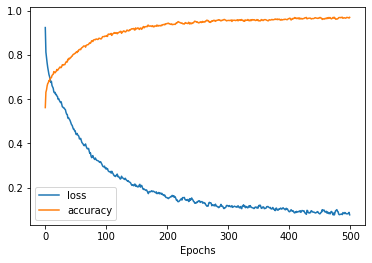

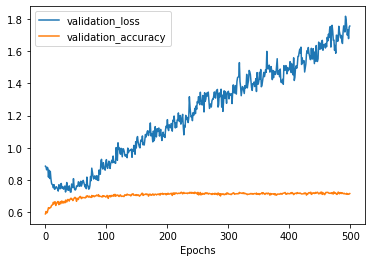

In [9]:
# νευρωνικό δίκτυο με επίπεδο εισόδου 60 νευρώνων, δύο κρυφά επίπεδα με 512 και 100 νευρώνες, sigmoid συνάρτηση ενεργοποίησης 
# και επίπεδο εξόδου με 3 νευρώνες με softmax συνάρτηση ενεργοποίησης

model = Sequential()
model.add(Input(60))
model.add(Dense(512,activation='sigmoid',use_bias=True))
model.add(Dense(100,activation='sigmoid',use_bias=True))
model.add(Dense(3,activation='softmax',use_bias=True))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_X,train_y,batch_size=32,epochs=500,validation_data=(test_X,test_y),shuffle=True)

#εμφάνιση αποτελεσμάτων
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['accuracy'],label="accuracy")
plt.legend()
plt.xlabel(xlabel="Epochs")
plt.show()

plt.plot(history.history['val_loss'],label="validation_loss")
plt.plot(history.history['val_accuracy'],label="validation_accuracy")
plt.legend()
plt.xlabel(xlabel="Epochs")
plt.show()

Epoch 1/500
337/337 [==============================] - 1s 4ms/step - loss: 0.9865 - accuracy: 0.5033 - val_loss: 0.8951 - val_accuracy: 0.5777
Epoch 2/500
337/337 [==============================] - 1s 4ms/step - loss: 0.8276 - accuracy: 0.6222 - val_loss: 0.8766 - val_accuracy: 0.5993
Epoch 3/500
337/337 [==============================] - 1s 4ms/step - loss: 0.7750 - accuracy: 0.6504 - val_loss: 0.8376 - val_accuracy: 0.6143
Epoch 4/500
337/337 [==============================] - 1s 4ms/step - loss: 0.7483 - accuracy: 0.6549 - val_loss: 0.8208 - val_accuracy: 0.6117
Epoch 5/500
337/337 [==============================] - 1s 4ms/step - loss: 0.7311 - accuracy: 0.6651 - val_loss: 0.8352 - val_accuracy: 0.6173
Epoch 6/500
337/337 [==============================] - 1s 4ms/step - loss: 0.7110 - accuracy: 0.6743 - val_loss: 0.7842 - val_accuracy: 0.6338
Epoch 7/500
337/337 [==============================] - 1s 4ms/step - loss: 0.6979 - accuracy: 0.6836 - val_loss: 0.8192 - val_accuracy: 0.6155

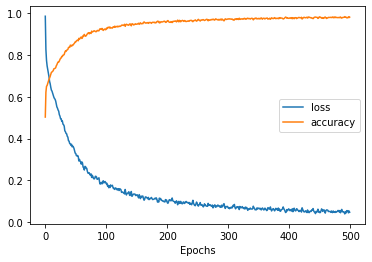

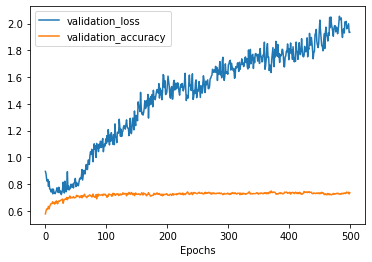

In [10]:
# νευρωνικό δίκτυο με επίπεδο εισόδου 60 νευρώνων, τρία κρυφά επίπεδα και sigmoid συνάρτηση ενεργοποίησης 
# και επίπεδο εξόδου με 3 νευρώνες με softmax συνάρτηση ενεργοποίησης

model = Sequential()
model.add(Input(60))
model.add(Dense(512,activation='sigmoid',use_bias=True))
model.add(Dense(256,activation='sigmoid',use_bias=True))
model.add(Dense(128,activation='sigmoid',use_bias=True))
model.add(Dense(64,activation='sigmoid',use_bias=True))
model.add(Dense(3,activation='softmax',use_bias=True))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_X,train_y,batch_size=32,epochs=500,validation_data=(test_X,test_y),shuffle=True)

#εμφάνιση αποτελεσμάτων
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['accuracy'],label="accuracy")
plt.legend()
plt.xlabel(xlabel="Epochs")
plt.show()

plt.plot(history.history['val_loss'],label="validation_loss")
plt.plot(history.history['val_accuracy'],label="validation_accuracy")
plt.legend()
plt.xlabel(xlabel="Epochs")
plt.show()

Epoch 1/500
337/337 [==============================] - 2s 6ms/step - loss: 0.7579 - accuracy: 0.6917 - val_loss: 0.4500 - val_accuracy: 0.8411
Epoch 2/500
337/337 [==============================] - 2s 6ms/step - loss: 0.2589 - accuracy: 0.9304 - val_loss: 0.2763 - val_accuracy: 0.8996
Epoch 3/500
337/337 [==============================] - 2s 6ms/step - loss: 0.0850 - accuracy: 0.9854 - val_loss: 0.2306 - val_accuracy: 0.9102
Epoch 4/500
337/337 [==============================] - 2s 5ms/step - loss: 0.0322 - accuracy: 0.9959 - val_loss: 0.2254 - val_accuracy: 0.9143
Epoch 5/500
337/337 [==============================] - 2s 6ms/step - loss: 0.0162 - accuracy: 0.9983 - val_loss: 0.2270 - val_accuracy: 0.9152
Epoch 6/500
337/337 [==============================] - 2s 6ms/step - loss: 0.0093 - accuracy: 0.9993 - val_loss: 0.2329 - val_accuracy: 0.9145
Epoch 7/500
337/337 [==============================] - 2s 6ms/step - loss: 0.0059 - accuracy: 0.9995 - val_loss: 0.2396 - val_accuracy: 0.9180

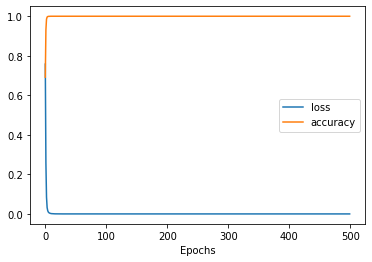

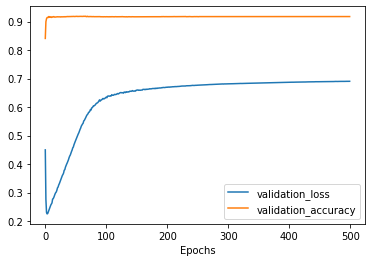

In [11]:
# νευρωνικό με Embedding layer ως αρχικό επίπεδο
# flatten επίπεδο για την μετατροπή των δεδομένων από 2D του προηγουμένου επιπέδου σε 1D
# ένα κρυφό επίπεδο με 25 νευρώνες και συνάρτηση ενεργοποίησης sigmoid
# επίπεδο εξόδου με 3 νευρώνες και συνάρτηση ενεργοποίησης softmax
model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=32, 
                           input_length=60))
model.add(Flatten())
model.add(Dense(25, activation='sigmoid'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_X,train_y,batch_size=32,epochs=500,validation_data=(test_X,test_y),shuffle=True)

#εμφάνιση αποτελεσμάτων
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['accuracy'],label="accuracy")
plt.legend()
plt.xlabel(xlabel="Epochs")
plt.show()

plt.plot(history.history['val_loss'],label="validation_loss")
plt.plot(history.history['val_accuracy'],label="validation_accuracy")
plt.legend()
plt.xlabel(xlabel="Epochs")
plt.show()


In [22]:
# Συνάρτηση που επιστρέφει το ποσοστό επιτυχίας (σε labels που είναι απλοί ακέραιοι)
# Ως όρισμα δέχεται δύο λίστες και υπολογίζει το ποσοστό στο οποίο είναι ίδιες
# Επιστρέφει το ποσοστό επιτυχίας
def accuracy1(y,d):
  e = [x1 for x1,x2 in zip(y,d) if x1 == x2]
  return len(e)/len(y)

Κατηγοριοποιητής 1 πλησιέστερου γείτονα

In [26]:
model = KNeighborsClassifier(n_neighbors=1,p=2)
model.fit(train_X, train_y1)

predicted_y1 = [] #αποτελέσματα
start = time.time()
for i in range(0,len(test_X)):
  y_i = model.predict([test_X[i]])
  predicted_y1 = np.append(predicted_y1,y_i)
end = time.time()
print("Test time: %f sec" %(end-start))
print("Accuracy: %f" %(accuracy1(predicted_y1,test_y1))) #εμφάνιση αποτελεσμάτων

Test time: 8.837096 sec
Accuracy: 0.727855


Κατηγοριοποιητής 3 πλησιέστερων γειτόνων

In [27]:
model = KNeighborsClassifier(n_neighbors=3,p=2)
model.fit(train_X, train_y1)

predicted_y2 = [] #αποτελέσματα
start = time.time()
for i in range(0,len(test_X)):
  y_i = model.predict([test_X[i]])
  predicted_y2 = np.append(predicted_y2,y_i)
end = time.time()
print("Test time: %f sec" %(end-start))
print("Accuracy: %f" %(accuracy1(predicted_y2,test_y1))) #εμφάνιση αποτελεσμάτων

Test time: 10.182206 sec
Accuracy: 0.694290


Κατηγοριοποιητής πλησιέστερου κέντρου

In [28]:
model = NearestCentroid(metric='euclidean')
start = time.time()
model.fit(train_X,train_y1)
end = time.time()
print("Training time: %f sec" %(end-start))

predicted_y3 = [] #αποτελέσματα 
start = time.time()
for i in range(0,len(test_X)):
  y_i = model.predict([test_X[i]])
  predicted_y3 = np.append(predicted_y3,y_i)
end = time.time()
print("Test time: %f sec" %(end-start))
print("Accuracy: %f" %(accuracy1(predicted_y3,test_y1))) #εμφάνιση αποτελεσμάτων

Training time: 0.009305 sec
Test time: 1.213204 sec
Accuracy: 0.365460
